# Analysis pipeline for Prolific data

In [316]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [317]:
import os

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from battleship.board import Board

In [318]:
%config InlineBackend.figure_format = 'retina'

# set seaborn color palette
sns.set_palette("Set2")

In [319]:
EXPERIMENT_NAME = "battleship-pilot-v1.1"

PATH_DATA = os.path.join("data", EXPERIMENT_NAME)
PATH_BATCH = os.path.join(PATH_DATA, "batch.csv")
PATH_GAME = os.path.join(PATH_DATA, "game.csv")
PATH_GLOBAL = os.path.join(PATH_DATA, "global.csv")
PATH_PLAYER = os.path.join(PATH_DATA, "player.csv")
PATH_ROUND = os.path.join(PATH_DATA, "round.csv")
PATH_STAGE = os.path.join(PATH_DATA, "stage.csv")

In [320]:
# For now, we're only using the round data
df_raw = pd.read_csv(PATH_ROUND)
df_raw

,id,answer,answerLastChangedAt,batchID,batchIDLastChangedAt,board_id,board_idLastChangedAt,bonus,bonusLastChangedAt,ended,endedLastChangedAt,gameID,gameIDLastChangedAt,gameOver,gameOverLastChangedAt,index,indexLastChangedAt,messages,messagesLastChangedAt,move,moveLastChangedAt,moves,movesLastChangedAt,name,nameLastChangedAt,occTiles,occTilesLastChangedAt,question,questionLastChangedAt,questionSkipped,questionSkippedLastChangedAt,questionsRemaining,questionsRemainingLastChangedAt,score,scoreLastChangedAt,ships,shipsLastChangedAt,shipsSunk,shipsSunkLastChangedAt,spotterRatings,spotterRatingsLastChangedAt,stageIndex,stageIndexLastChangedAt,start,startLastChangedAt,trueTiles,trueTilesLastChangedAt
0,01J4Z7BZ4CAR2THM64A3QCVCA1,(answer timed out),2024-08-10T22:55:08.020565352Z,01J4Z64VVMDTNEHV92W28MQSFM,2024-08-10T22:43:25.452564556Z,3,2024-08-10T22:43:25.634751425Z,20.0,2024-08-10T22:51:54.215735753Z,True,2024-08-10T22:55:10.549902344Z,01J4Z64VWHTW5BXA7M1TFRR6PE,2024-08-10T22:43:25.452564556Z,True,2024-08-10T22:55:10.28978145Z,3,2024-08-10T22:43:25.452564556Z,"[{""text"":""Is the largest ship verticle?"",""type...",2024-08-10T22:55:07.963239146Z,C8,2024-08-10T22:55:07.768395496Z,"[""C3"",""D2"",""D1"",""E1"",""F1"",""C1"",""B1"",""G1"",""D5"",...",2024-08-10T22:55:07.751922908Z,Round,2024-08-10T22:43:25.452564556Z,"[[-1,-1,0,-1,-1,0,-1,-1],[0,-1,3,3,3,0,-1,-1],...",2024-08-10T22:55:07.73258291Z,(question skipped),2024-08-10T22:54:53.204338747Z,False,2024-08-10T22:44:26.794521346Z,1,2024-08-10T22:54:34.385212524Z,24,2024-08-10T22:55:07.963239146Z,"[1,2,3,4]",2024-08-10T22:43:25.634751425Z,"[[1,[true,5]],[2,[true,2]],[3,[true,3]],[4,[tr...",2024-08-10T22:55:07.963239146Z,"[[""Is the largest ship verticle?"",""3""],[""Is th...",2024-08-10T22:54:15.755656936Z,74,2024-08-10T22:55:07.963239146Z,True,2024-08-10T22:43:25.526272666Z,"[[0,0,0,0,0,0,0,0],[0,0,3,3,3,0,0,0],[1,0,0,0,...",2024-08-10T22:43:25.634751425Z
1,01J4Z8BY8SBYPEM151HEVFNRAG,(answer timed out),2024-08-10T23:07:22.903014605Z,01J4Z64M0PDE62RT26ZS4S4YQ7,2024-08-10T23:00:53.145048629Z,5,2024-08-10T23:00:53.316303218Z,25.0,2024-08-10T23:07:11.344743432Z,True,2024-08-10T23:07:31.554502152Z,01J4Z64M1N0KWWXQWWVMGV69NJ,2024-08-10T23:00:53.145048629Z,True,2024-08-10T23:07:24.130818967Z,5,2024-08-10T23:00:53.145048629Z,"[{""text"":""Is there a hit on D4?"",""type"":""quest...",2024-08-10T23:07:22.872567356Z,G7,2024-08-10T23:07:22.803314174Z,"[""D5"",""C5"",""B5"",""A5"",""E5"",""F5"",""H3"",""D3"",""B3"",...",2024-08-10T23:07:22.744716412Z,Round,2024-08-10T23:00:53.145048629Z,"[[-1,-1,-1,-1,0,-1,-1,-1],[-1,4,4,-1,1,-1,-1,-...",2024-08-10T23:07:22.722257548Z,(question skipped),2024-08-10T23:06:05.898141343Z,False,2024-08-10T23:01:23.39109419Z,0,2024-08-10T23:05:53.919284498Z,19,2024-08-10T23:07:22.872567356Z,"[1,2,3,4]",2024-08-10T23:00:53.316303218Z,"[[1,[true,5]],[2,[true,3]],[3,[true,4]],[4,[tr...",2024-08-10T23:07:22.872567356Z,"[[""Is there a hit on D4?"",""4""],[""Should I hit ...",2024-08-10T23:05:38.789712209Z,58,2024-08-10T23:07:22.872567356Z,True,2024-08-10T23:00:53.228654745Z,"[[0,0,0,0,0,0,0,0],[0,4,4,0,1,0,0,0],[0,0,0,0,...",2024-08-10T23:00:53.316303218Z
2,01J4Z8R3CVG3AAVB8TT63HBRJF,(answer timed out),2024-08-10T23:13:02.069815115Z,01J4Z64M0PDE62RT26ZS4S4YQ7,2024-08-10T23:07:31.611544766Z,6,2024-08-10T23:07:31.804914115Z,20.0,2024-08-10T23:12:26.296633855Z,True,2024-08-10T23:13:14.250058981Z,01J4Z64M1N0KWWXQWWVMGV69NJ,2024-08-10T23:07:31.611544766Z,True,2024-08-10T23:13:03.530315047Z,6,2024-08-10T23:07:31.611544766Z,"[{""text"":""do any ships intersect row A"",""type""...",2024-08-10T23:13:02.003111015Z,B8,2024-08-10T23:13:00.98028591Z,"[""B4"",""C4"",""D6"",""D2"",""C2"",""B2"",""A2"",""G3"",""F3"",...",2024-08-10T23:13:00.956949537Z,Round,2024-08-10T23:07:31.611544766Z,"[[-1,3,-1,-1,-1,-1,-1,-1],[-1,3,-1,1,0,4,4,4],...",2024-08-10T23:13:00.935032856Z,(question skipped),2024-08-10T23:11:22.883066187Z,False,2024-08-10T23:07:54.924482437Z,0,2024-08-10T23:11:16.465515587Z,

## Data reformatting

In [321]:
df = df_raw.copy()

# rename id to roundID
df = df.rename(mapper={"id": "roundID"}, axis=1)

# drop all columns that end with LastChangedAt
df = df.loc[:, ~df.columns.str.endswith("LastChangedAt")]

# parse 'messages' from JSON to Python object
df["messages"] = df["messages"].apply(json.loads)

# explode 'messages' into separate rows
df = df.explode("messages")

# unpack each row of messages into 'message_text', 'message_type', 'message_time'
# this will add more rows to the df
_df_messages = df["messages"].apply(pd.Series).drop(columns=[0])
_df_messages = _df_messages.rename(
    mapper={col_name: f"message_{col_name}" for col_name in _df_messages.columns},
    axis=1,
)

df = pd.concat([df, _df_messages], axis=1).reset_index(drop=True)

df

,roundID,answer,batchID,board_id,bonus,ended,gameID,gameOver,index,messages,move,moves,name,occTiles,question,questionSkipped,questionsRemaining,score,ships,shipsSunk,spotterRatings,stageIndex,start,trueTiles,message_text,message_type,message_time
0,01J4Z7BZ4CAR2THM64A3QCVCA1,(answer timed out),01J4Z64VVMDTNEHV92W28MQSFM,3,20.0,True,01J4Z64VWHTW5BXA7M1TFRR6PE,True,3,"{'text': 'Is the largest ship verticle?', 'typ...",C8,"[""C3"",""D2"",""D1"",""E1"",""F1"",""C1"",""B1"",""G1"",""D5"",...",Round,"[[-1,-1,0,-1,-1,0,-1,-1],[0,-1,3,3,3,0,-1,-1],...",(question skipped),False,1,24,"[1,2,3,4]","[[1,[true,5]],[2,[true,2]],[3,[true,3]],[4,[tr...","[[""Is the largest ship verticle?"",""3""],[""Is th...",74,True,"[[0,0,0,0,0,0,0,0],[0,0,3,3,3,0,0,0],[1,0,0,0,...",Is the largest ship verticle?,question,34340.0
1,01J4Z7BZ4CAR2THM64A3QCVCA1,(answer timed out),01J4Z64VVMDTNEHV92W28MQSFM,3,20.0,True,01J4Z64VWHTW5BXA7M1TFRR6PE,True,3,"{'text': 'yes', 'type': 'answer', 'time': 6700}",C8,"[""C3"",""D2"",""D1"",""E1"",""F1"",""C1"",""B1"",""G1"",""D5"",...",Round,"[[-1,-1,0,-1,-1,0,-1,-1],[0,-1,3,3,3,0,-1,-1],...",(question skipped),False,1,24,"[1,2,3,4]","[[1,[true,5]],[2,[true,2]],[3,[true,3]],[4,[tr...","[[""Is the largest ship verticle?"",""3""],[""Is th...",74,True,"[[0,0,0,0,0,0,0,0],[0,0,3,3,3,0,0,0],[1,0,0,0,...",yes,answer,6700.0
2,01J4Z7BZ4CAR2THM64A3QCVCA1,(answer timed out),01J4Z64VVMDTNEHV92W28MQSFM,3,20.0,True,01J4Z64VWHTW5BXA7M1TFRR6PE,True,3,"{'text': 'C3', 'type': 'move', 'time': 10886}",C8,"[""C3"",""D2"",""D1"",""E1"",""F1"",""C1"",""B1"",""G1"",""D5"",...",Round,"[[-1,-1,0,-1,-1,0,-1,-1],[0,-1,3,3,3,0,-1,-1],...",(question skipped),False,1,24,"[1,2,3,4]","[[1,[true,5]],[2,[true,2]],[3,[true,3]],[4,[tr...","[[""Is the largest ship verticle?"",""3""],[""Is th...",74,True,"[[0,0,0,0,0,0,0,0],[0,0,3,3,3,0,0,0],[1,0,0,0,...",C3,move,10886.0
3,01J4Z7BZ4CAR2THM64A3QCVCA1,(answer timed out),01J4Z64VVMDTNEHV92W28MQSFM,3,20.0,True,01J4Z64VWHTW5BXA7M1TFRR6PE,True,3,{'text': 'Is the largest ship to right or left...,C8,"[""C3"",""D2"",""D1"",""E1"",""F1"",""C1"",""B1"",""G1"",""D5"",...",Round,"[[-1,-1,0,-1,-1,0,-1,-1],[0,-1,3,3,3,0,-1,-1],...",(question skipped),False,1,24,"[1,2,3,4]","[[1,[true,5]],[2,[true,2]],[3,[true,3]],[4,[tr...","[[""Is the largest ship verticle?"",""3""],[""Is th...",74,True,"[[0,0,0,0,0,0,0,0],[0,0,3,3,3,0,0,0],[1,0,0,0,...",Is the largest ship to right or left of number...,question,81111.0
4,01J4Z7BZ4CAR2THM64A3QCVCA1,(answer timed out),01J4Z64VVMDTNEHV92W28MQSFM,3,20.0,True,01J4Z64VWHTW5BXA7M1TFRR6PE,True,3,"{'text': 'yes', 'type': 'answer', 'time': 14806}",C8,"[""C3"",""D2"",""D1"",""E1"",""F1"",""C1"",""B1"",""G1"",""D5"",...",Round,"[[-1,-1,0,-1,-1,0,-1,-1],[0,-1,3,3,3,0,-1,-1],...",(question skipped),False,1,24,"[1,2,3,4]","[[1,[true,5]],[2,[true,2]],[3,[true,3]],[4,[tr...","[[""Is the largest ship verticle?"",""3""],[""Is th...",74,True,"[[0,0,0,0,0,0,0,0],[0,0,3,3,3,0,0,0],[1,0,0,0,...",yes,answer,14806.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3706,01J4Z7KEWW5AQ1PX2BEDCGSRPA,(answer timed out),01J4Z64QH4ZPZJQ3HQ95N7X641,4,25.0,True,01J4Z64QJ37PZ8VEA785SXN3SV,True,4,"{'text': '(no question asked)', 'type': 'answe...",C8,"[""D1"",""E1"",""C1"",""D2"",""D3"",""D4"",""D5"",""C6"",""B6"",...",Round,"[[-1,-1,-1,-1,-1,-1,-1,3],[-1,-1,-1,-1,-1,0,-1...",(question skipped),False,5,19,"[1,2,3,4]","[[1,[true,4]],[2,[true,2]],[3,[true,3]],[4,[tr...","[[""Are there any ships vertically placed on ei...",58,True,"[[0,0,0,0,0,0,0,3],[0,0,0,0,0,0,0,3],[0,0,0,0,...",(no question asked),answer,0.0
3707,01J4Z7KEWW5AQ1PX2BEDCGSRPA,(answer timed out),01J4Z64QH4ZPZJQ3HQ95N7X641,4,25.0,True,01J4Z64QJ37PZ8VEA785SXN3SV,True,4,"{'text': 'B8', 'type': 'move', 'time': 0}",C8,"[""D1"",""E1"",""C1"",""D2"",""D3"",""D4"",""D5"",""C6"",""B6"",...",Round,"[[-1,-1,-1,-1,-1,-1,-1,3],[-1,-1,-1,-1,-1,0,-1...",(question skipped),False,5,19,"[1,2,3,4]","[[1,[true,4]],[2,[tr

# Visualizations

## Number of moves to win

In [322]:
df_move_counts = (
    df[(df["message_type"] == "move") & ~df["board_id"].isin(["test_1", "test_2"])]
    .groupby(["gameID", "board_id"])
    .size()
    .to_frame("move_count")
)
df_move_counts

move_count
gameID                     board_id            
01J4WE7W6AQ3FWBHCF1C96ACZ3 3                 25
                           4                 31
                           5                 27
                           6                 22
                           7                 24
                           8                 46
01J4WE7W6AQ3FWBHCF1R0XKX3K 3                 20
                           4                 29
                           5                 28
                           6                 35
                           7                 26
                           8                 27
01J4Z64M1N0KWWXQWWVMGV69NJ 3                 26
                           4                 27
                           5                 19
                           6                 21
                           7                 19
                           8                 32
01J4Z64QJ37PZ8VEA785SXN3SV 3                 40
                           4                 19
                           5                 18
                           6                 26
                           7                 20
                           8                 18
01J4Z64SSDYEF98TZ2SFHM381N 3                 45
                           4                 30
                           5                 26
                           6                 33
                           7                 58
                           8                 29
01J4Z64VWHTW5BXA7M1TFRR6PE 3                 24
                           4                 32
                           5                 25
                           6                 21
                           7                 25
                           8                 26
01J4Z654PW47GSKPFJPJ5AS4YF 3                 35
                           4                 27
                           5                 24
                           6                 30
                           7                 19
                           8                 30

In [323]:
df_question_counts = df[
    (df["message_type"] == "question")
    & (df["message_text"] != "(question skipped)")
    & ~df["board_id"].isin(["test_1", "test_2"])
]
df_question_counts = (
    df_question_counts.groupby(["gameID", "board_id"]).size().to_frame("question_count")
)
df_question_counts

question_count
gameID                     board_id                
01J4WE7W6AQ3FWBHCF1C96ACZ3 3                      7
                           4                      7
                           5                      3
                           6                      4
                           7                      1
                           8                      2
01J4WE7W6AQ3FWBHCF1R0XKX3K 3                      2
                           5                      1
                           6                      1
                           7                      2
                           8                      1
01J4Z64M1N0KWWXQWWVMGV69NJ 3                     10
                           4                     10
                           5                     10
                           6                     10
                           7                     10
                           8                     10
01J4Z64QJ37PZ8VEA785SXN3SV 3                     10
                           4                      5
                           5                     10
                           6                     10
                           7                     10
                           8                     10
01J4Z64VWHTW5BXA7M1TFRR6PE 3                      9
                           4                     10
                           5                      7
                           6                     10
                           7                      7
                           8                      7
01J4Z654PW47GSKPFJPJ5AS4YF 3                     10
                           4                     10
                           5                     10
                           6                     10
                           7                     10
                           8                     10

In [328]:
df_counts = df_move_counts.join(df_question_counts)
# replace null values with 0
df_counts = df_counts.fillna(0)
df_counts["question_count"] = df_counts["question_count"].astype(int)
df_counts = df_counts.sort_values(["gameID", "board_id"]).reset_index(drop=False)
df_counts

,gameID,board_id,move_count,question_count
0,01J4WE7W6AQ3FWBHCF1C96ACZ3,3,25,7
1,01J4WE7W6AQ3FWBHCF1C96ACZ3,4,31,7
2,01J4WE7W6AQ3FWBHCF1C96ACZ3,5,27,3
3,01J4WE7W6AQ3FWBHCF1C96ACZ3,6,22,4
4,01J4WE7W6AQ3FWBHCF1C96ACZ3,7,24,1
5,01J4WE7W6AQ3FWBHCF1C96ACZ3,8,46,2
6,01J4WE7W6AQ3FWBHCF1R0XKX3K,3,20,2
7,01J4WE7W6AQ3FWBHCF1R0XKX3K,4,29,0
8,01J4WE7W6AQ3FWBHCF1R0XKX3K,5,28,1
9,01J4WE7W6AQ3FWBHCF1R0XKX3K,6,35,1


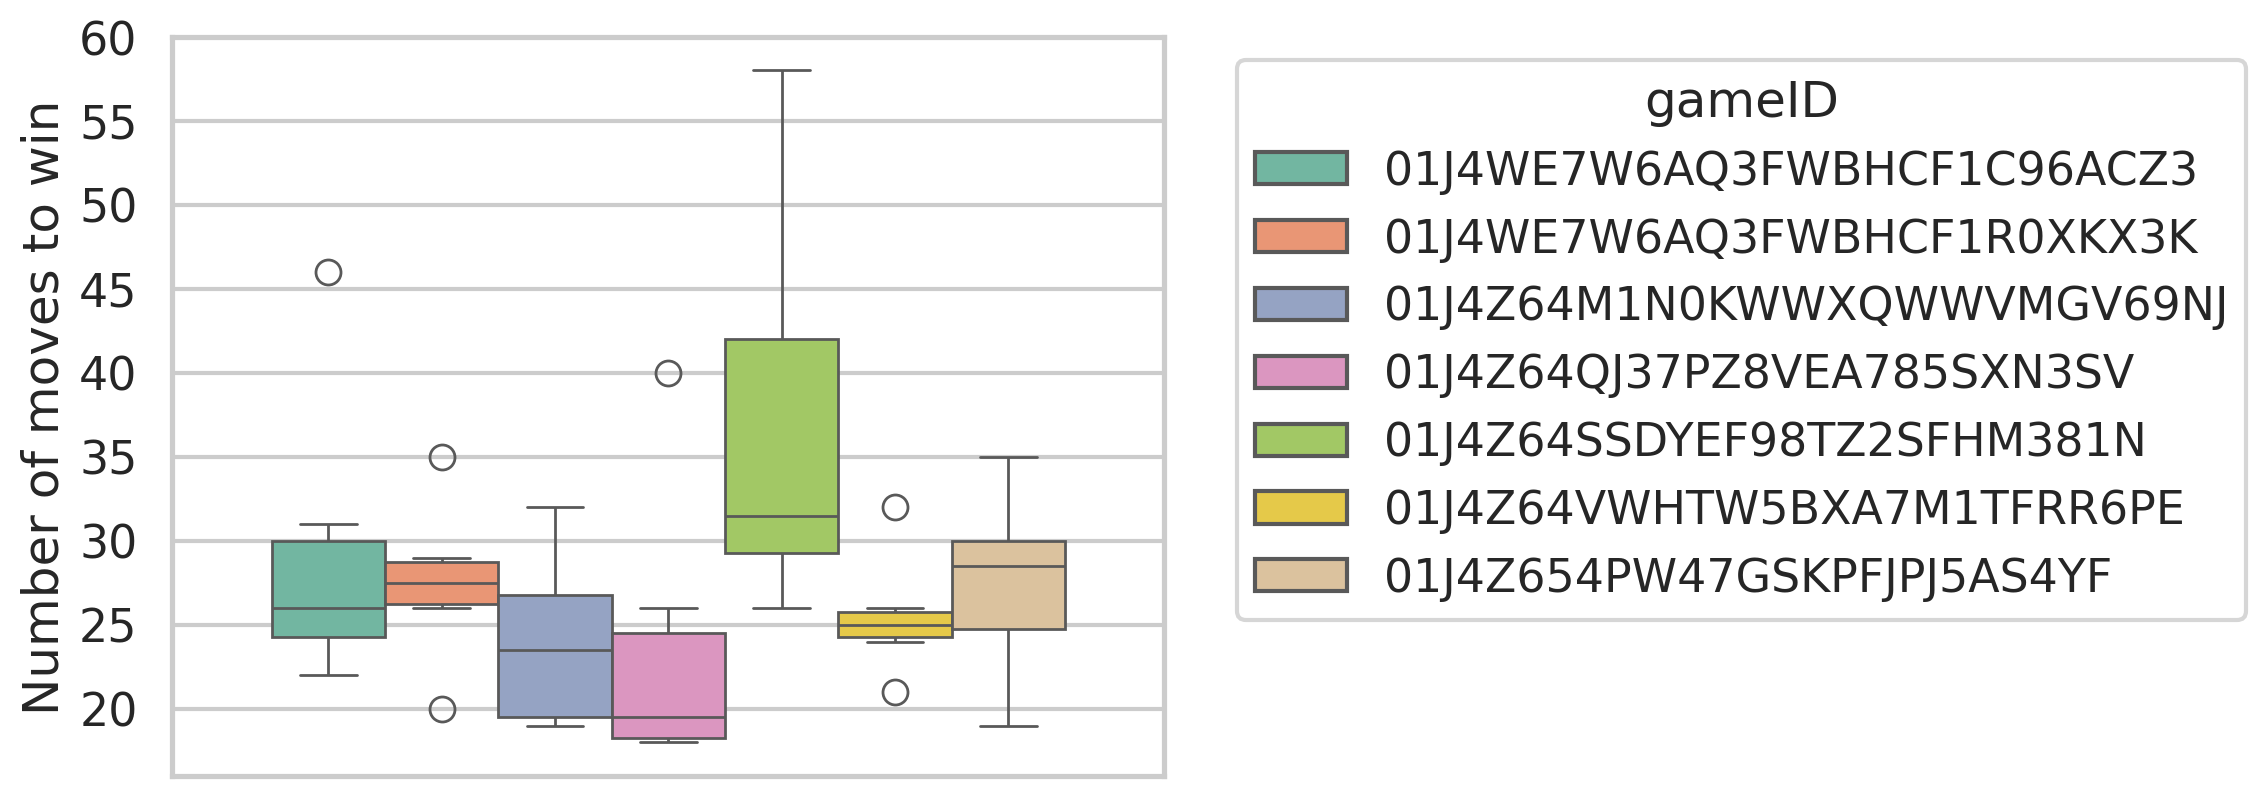

In [325]:
with sns.plotting_context("talk"), sns.axes_style("whitegrid"):

    sns.boxplot(
        data=df_counts,
        y="move_count",
        hue="gameID",
        hue_order=df_counts["gameID"].unique(),
    )

    plt.ylabel("Number of moves to win")

    # move legend outside of plot
    plt.legend(title="gameID", bbox_to_anchor=(1.05, 1), loc="upper left")

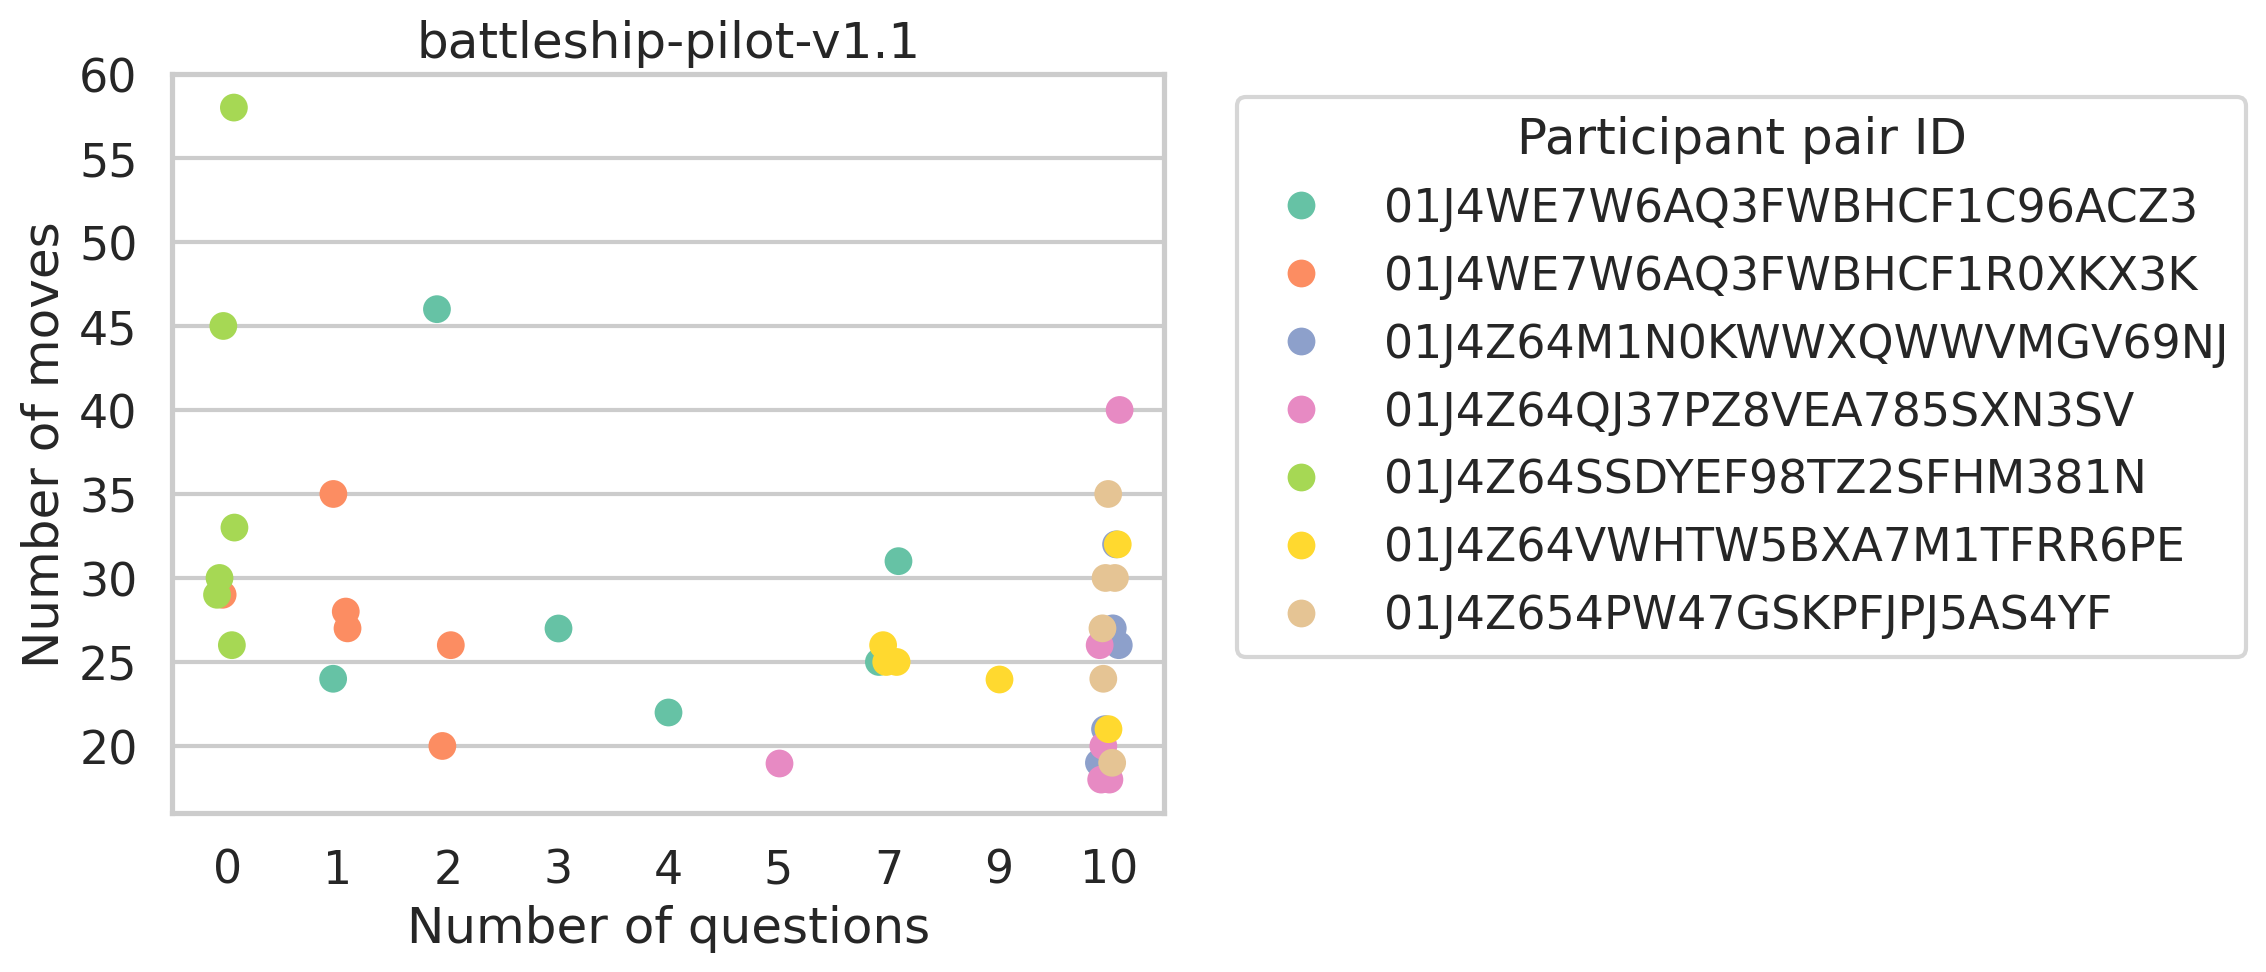

In [326]:
with sns.plotting_context("talk"), sns.axes_style("whitegrid"):

    sns.stripplot(
        data=df_counts,
        x="question_count",
        y="move_count",
        hue="gameID",
        hue_order=df_counts["gameID"].unique(),
        size=10.0,
    )

    plt.xlabel("Number of questions")
    plt.ylabel("Number of moves")

    # move legend outside of plot
    plt.legend(title="Participant pair ID", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title(f"{EXPERIMENT_NAME}")